Integrantes del equipo:
- Alonso Cañas Rico
- Hugo Jiménez García

# Parameters

In [1]:
EPOCHS = 20
LEARNING_RATE = 3e-5
BATCH_SIZE = 256
LAYERS_TO_TRAIN = 0

In [2]:
ai_generated_path = "pan24-generative-authorship-news/machines"
human_path = "pan24-generative-authorship-news/human.jsonl"

# Initial config

## Libraries

In [3]:
import os
import json
import warnings
import logging
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score, 
    brier_score_loss, fbeta_score
)

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from transformers import BertTokenizer, BertModel, AdamW

c:\Users\Alonso\Documents\## UPM\MASTER\NLP\practica\NLP\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Device

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
warnings.filterwarnings("ignore", message=".*overflowing tokens.*")
logging.disable(logging.WARNING)

# Data

## Import data

In [6]:
model, id, text = [], [], []

# Loop through every file in the directory
for filename in os.listdir(ai_generated_path):
    # Check if the file is a JSONL file
    if filename.endswith('.jsonl'):
        filepath = os.path.join(ai_generated_path, filename)
        with open(filepath, 'r', encoding='utf-8') as jsonl_file:
            for line in jsonl_file:
                # Each line is a separate JSON object
                data = json.loads(line)
                model.append(filename)
                id.append(data['id'])
                text.append(data['text'])

df_generated = pd.DataFrame({'model': model, 'id': id, 'text': text, 'ai_generated': 1})
df_generated

,model,id,text,ai_generated
0,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Inaugural Address: President Joseph R. Biden J...,1
1,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Setting the Record Straight: Fact-Checking the...,1
2,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Joe Biden Takes the Oath of Office as 46th Pre...,1
3,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Joe Biden Takes Oath as 46th President of Unit...,1
4,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Amanda Gorman's Inspiring Poem Celebrates Hope...,1
...,...,...,...,...
14126,vicgalle-gpt2-open-instruct-v1.jsonl,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,'The Disappearance of Gabby Petito' – A Compre...,1
14127,vicgalle-gpt2-open-instruct-v1.jsonl,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,"Utah State Police Search for Gabby Petito, Tra...",1
14128,vicgalle-gpt2-open-instruct-v1.jsonl,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,McKenna's Lost Friend: Debunking the Evidence ...,1
14129,vicgalle-gpt2-open-instruct-v1.jsonl,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,"""Gunshots Found in Florida Nature Preserve: A ...",1


In [7]:
id, text = [], []

with open(human_path, 'r', encoding='utf-8') as jsonl_file:
    for line in jsonl_file:
        # Each line is a separate JSON object
        data = json.loads(line)
        id.append(data['id'])
        text.append(data['text'])

df_human = pd.DataFrame({'model': 'Human', 'id': id, 'text': text, 'ai_generated': 0})
df_human

,model,id,text,ai_generated
0,Human,articles-cleaned-truncated/news-2021-01-01-202...,Inaugural Address by President Joseph R. Biden...,0
1,Human,articles-cleaned-truncated/news-2021-01-01-202...,Fact check: Biden inauguration impacted by pan...,0
2,Human,articles-cleaned-truncated/news-2021-01-01-202...,Highlights from Joe Biden's 2021 inauguration\...,0
3,Human,articles-cleaned-truncated/news-2021-01-01-202...,"Biden takes the helm, appeals for unity to tak...",0
4,Human,articles-cleaned-truncated/news-2021-01-01-202...,'The Hill We Climb': Read Amanda Gorman's inau...,0
...,...,...,...,...
1082,Human,articles-cleaned-truncated/news-2021-01-01-202...,How amateur detectives on social media helped ...,0
1083,Human,articles-cleaned-truncated/news-2021-01-01-202...,Authorities searching for missing 22-year-old ...,0
1084,Human,articles-cleaned-truncated/news-2021-01-01-202...,Univ. of Wisconsin Oshkosh student helping Gab...,0
1085,Human,articles-cleaned-truncated/news-2021-01-01-202...,Did the Internet Actually Help Find Gabby Peti...,0


In [8]:
df = pd.concat([df_generated, df_human])[['text', 'ai_generated', 'id']]
df

,text,ai_generated,id
0,Inaugural Address: President Joseph R. Biden J...,1,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
1,Setting the Record Straight: Fact-Checking the...,1,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
2,Joe Biden Takes the Oath of Office as 46th Pre...,1,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
3,Joe Biden Takes Oath as 46th President of Unit...,1,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
4,Amanda Gorman's Inspiring Poem Celebrates Hope...,1,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
...,...,...,...
1082,How amateur detectives on social media helped ...,0,articles-cleaned-truncated/news-2021-01-01-202...
1083,Authorities searching for missing 22-year-old ...,0,articles-cleaned-truncated/news-2021-01-01-202...
1084,Univ. of Wisconsin Oshkosh student helping Gab...,0,articles-cleaned-truncated/news-2021-01-01-202...
1085,Did the Internet Actually Help Find Gabby Peti...,0,articles-cleaned-truncated/news-2021-01-01-202...


## Make combinations of text pairs

In [9]:
test_size = 0.25
val_size = 0.125
_adjusted_val_size = val_size / (1 - test_size)

# Extraer el segundo y tercer segmento de los IDs
df['base_id'] = df['id'].apply(lambda x: '/'.join(x.split('/')[1:]))  # Coger los ids sin la parte que identifica al autor del fragmento de texto.

# Paso 1: Dividir los datos según los `base_id`
base_ids = df['base_id'].unique()
train_base_ids, test_base_ids = train_test_split(base_ids, test_size=test_size, random_state=1337)
train_base_ids, val_base_ids = train_test_split(train_base_ids, test_size=_adjusted_val_size, random_state=1337) 

# Crear DataFrames por conjunto
train = df[df['base_id'].isin(train_base_ids)]
val = df[df['base_id'].isin(val_base_ids)]
test = df[df['base_id'].isin(test_base_ids)]

train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print(f"train shape: {train.shape}")
print(f"val shape: {val.shape}")
print(f"test shape: {test.shape}")

train shape: (9506, 4)
val shape: (1904, 4)
test shape: (3808, 4)


In [10]:
def create_combinations_within_id(df):
    # Lista para almacenar las combinaciones de cada `base_id`
    combinations = []
    
    # Iterar sobre cada `base_id`
    for _, group in df.groupby('base_id'):
        # Filtrar textos humanos e IA dentro del grupo
        df_human = group[group['ai_generated'] == 0][['text']].reset_index(drop=True)
        df_ia = group[group['ai_generated'] == 1][['text']].reset_index(drop=True)
        
        # Producto cartesiano dentro del `base_id`
        cartesian_df = df_human.merge(df_ia, how='cross', suffixes=('_human', '_ia'))
        cartesian_df = cartesian_df.sample(frac=1).reset_index(drop=True)
        
        # Crear las dos disposiciones
        total_combinations = len(cartesian_df)
        
        half_1 = cartesian_df.iloc[:total_combinations // 2].copy()
        half_1['comment_text_1'] = half_1['text_human']
        half_1['comment_text_2'] = half_1['text_ia']
        half_1['list'] = 0  # Etiqueta 0
        
        half_2 = cartesian_df.iloc[total_combinations // 2:].copy()
        half_2['comment_text_1'] = half_2['text_ia']
        half_2['comment_text_2'] = half_2['text_human']
        half_2['list'] = 1  # Etiqueta 1
        
        # Combinar y agregar al resultado final
        balanced_df = pd.concat([half_1, half_2], ignore_index=True)
        combinations.append(balanced_df)
    
    # Concatenar todas las combinaciones y barajar
    return pd.concat(combinations, ignore_index=True).sample(frac=1).reset_index(drop=True)


In [11]:
# Generar combinaciones restringidas por `id` para cada conjunto
train = create_combinations_within_id(train)
val = create_combinations_within_id(val)
test = create_combinations_within_id(test)

In [12]:
# Print the dimensions
print(f"train shape: {train.shape} / Text on comment_text_1 is human-generated: {train['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {train['list'].value_counts()[1]}")
print(f"val shape: {val.shape} / Text on comment_text_1 is human-generated: {val['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {val['list'].value_counts()[1]}")
print(f"test shape: {test.shape} / Text on comment_text_1 is human-generated: {test['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {test['list'].value_counts()[1]}")

train shape: (8827, 5) / Text on comment_text_1 is human-generated: 4074 - Text on comment_text_2 is human-generated: 4753
val shape: (1768, 5) / Text on comment_text_1 is human-generated: 816 - Text on comment_text_2 is human-generated: 952
test shape: (3536, 5) / Text on comment_text_1 is human-generated: 1632 - Text on comment_text_2 is human-generated: 1904


# Model

In [13]:
# Tokenizador y modelo
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
individual_model = BertModel.from_pretrained(model_name).from_pretrained(model_name, num_labels=2)

In [14]:
for param in individual_model.parameters():
    param.requires_grad = False
if LAYERS_TO_TRAIN > 0:
    for layer in individual_model.encoder.layer[-LAYERS_TO_TRAIN:]:
        for param in layer.parameters():
            param.requires_grad = True

for param in individual_model.pooler.dense.parameters():
    param.requires_grad = True

# Verify that only the classifier layer is trainable
for name, param in individual_model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

embeddings.word_embeddings.weight: requires_grad = False
embeddings.position_embeddings.weight: requires_grad = False
embeddings.token_type_embeddings.weight: requires_grad = False
embeddings.LayerNorm.weight: requires_grad = False
embeddings.LayerNorm.bias: requires_grad = False
encoder.layer.0.attention.self.query.weight: requires_grad = False
encoder.layer.0.attention.self.query.bias: requires_grad = False
encoder.layer.0.attention.self.key.weight: requires_grad = False
encoder.layer.0.attention.self.key.bias: requires_grad = False
encoder.layer.0.attention.self.value.weight: requires_grad = False
encoder.layer.0.attention.self.value.bias: requires_grad = False
encoder.layer.0.attention.output.dense.weight: requires_grad = False
encoder.layer.0.attention.output.dense.bias: requires_grad = False
encoder.layer.0.attention.output.LayerNorm.weight: requires_grad = False
encoder.layer.0.attention.output.LayerNorm.bias: requires_grad = False
encoder.layer.0.intermediate.dense.weight: requ

In [ ]:
class TransformerClass(torch.nn.Module):
    def __init__(self, bert_model):
        super(TransformerClass, self).__init__()
        self.l1 = bert_model
        self.l2 = torch.nn.Linear(768, 768)
        self.l3 = torch.nn.Dropout(0.)
        self.l4 = torch.nn.CosineSimilarity(dim=1)
        self.l5 = torch.nn.Linear(1, 1)

    def forward(self, ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1):
        last_hidden_state_a = self.l1(ids_0, attention_mask=mask_0, token_type_ids=token_type_ids_0).last_hidden_state[:, 0]
        last_hidden_state_b = self.l1(ids_1, attention_mask=mask_1, token_type_ids=token_type_ids_1).last_hidden_state[:, 0]

        x_a, x_b = self.l2(last_hidden_state_a), self.l2(last_hidden_state_b)
        x_a, x_b = F.gelu(self.l3(x_a)), F.gelu(self.l3(x_b))
        sem_sim = self.l4(x_a, x_b).unsqueeze(1) 
        return torch.sigmoid(self.l5(sem_sim))

model = TransformerClass(individual_model)
model.to(device)

TransformerClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

# Training

## Loss and optimizer

In [16]:
loss_fn = torch.nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

c:\Users\Alonso\Documents\## UPM\MASTER\NLP\practica\NLP\venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Data Generators

In [17]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text_1 = dataframe.comment_text_1
        self.comment_text_2 = dataframe.comment_text_2
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        comment_text_1 = str(self.comment_text_1[index])
        comment_text_1 = " ".join(comment_text_1.split())
        comment_text_2 = str(self.comment_text_2[index])
        comment_text_2 = " ".join(comment_text_2.split())
        inputs0 = self.tokenizer(comment_text_1, 
                                max_length=self.max_len,
                                padding="max_length",
                                truncation=True,
                                return_overflowing_tokens=False,
                                return_token_type_ids=True)
        inputs1 = self.tokenizer(comment_text_2,
                                max_length=self.max_len,
                                padding="max_length",
                                truncation=True,
                                return_overflowing_tokens=False,
                                return_token_type_ids=True)
        return {
            'ids_0': torch.tensor(inputs0.input_ids, dtype=torch.long),
            'mask_0': torch.tensor(inputs0.attention_mask, dtype=torch.long),
            'token_type_ids_0': torch.tensor(inputs0.token_type_ids, dtype=torch.long),
            'ids_1': torch.tensor(inputs1.input_ids, dtype=torch.long),
            'mask_1': torch.tensor(inputs1.attention_mask, dtype=torch.long),
            'token_type_ids_1': torch.tensor(inputs1.token_type_ids, dtype=torch.long),
            'labels': torch.tensor(self.targets[index], dtype=torch.long)
          }

In [18]:
# Instancia el dataset
train_dataset = CustomDataset(dataframe=train, tokenizer=tokenizer, max_len=512)
val_dataset = CustomDataset(dataframe=val, tokenizer=tokenizer, max_len=512)
test_dataset = CustomDataset(dataframe=test, tokenizer=tokenizer, max_len=512)

In [19]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Training and metrics methods

In [20]:
def c_at_1(targets, preds):
    """
    Calculates the C@1 metric:
    - Non-answers (predictions marked as -1) are given a score of 0.5.
    - Remaining cases are scored based on accuracy.
    
    Parameters:
        targets (np.array): Ground truth labels.
        preds (np.array): Predictions, where -1 indicates a non-answer.
    
    Returns:
        float: C@1 metric.
    """
    correct = (targets == preds)  # Boolean array for correct predictions
    unanswered = preds == -1     # Boolean array for non-answers
    
    num_correct = correct.sum()
    num_total = len(targets)
    num_unanswered = unanswered.sum()
    
    return (num_correct + num_unanswered * 0.5) / num_total

In [21]:
# Función de entrenamiento
def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0

    # Use tqdm to wrap the loader for a progress bar
    for batch in tqdm(loader, desc="Training", leave=True):
        labels = batch['labels'].unsqueeze(1).to(device).float()
        batch = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        outputs = model(**batch)

        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

# Función de evaluación
def evaluate(model, loader, device):
    model.eval()
    preds, targets, probabilities = [], [], []

    with torch.no_grad():
        for batch in loader:
            labels = batch['labels'].unsqueeze(1).float()
            batch = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**batch)
            probabilities.extend(outputs.cpu().numpy())
            preds.extend(torch.round(outputs).cpu().numpy())
            targets.extend(labels.cpu().numpy())
    
    targets = np.array(targets).flatten()
    preds = np.array(preds).flatten()
    probabilities = np.array(probabilities).flatten()
    
    # Calculate metrics
    roc_auc = roc_auc_score(targets, probabilities)
    brier = brier_score_loss(targets, probabilities)
    f1 = f1_score(targets, preds)
    f05u = fbeta_score(targets, preds, beta=0.5)
    c1 = c_at_1(targets, preds)
    mean = np.mean([roc_auc, 1-brier, c1, f1, f05u])
    
    return {
        "accuracy": accuracy_score(targets, preds),
        "roc-auc": roc_auc,
        "brier": brier,
        "c@1": c1,
        "f1": f1,
        "f05u": f05u,
        "mean": mean,
    }

## Training

In [ ]:
history = {
    "train_loss": [],
    "train_metrics": [],
    "val_metrics": []
}

save_path = f"models/models_siames_bert_congelado/fine_tuned_model_{EPOCHS}_epochs_{LEARNING_RATE}_lr_{LAYERS_TO_TRAIN}_layers_{BATCH_SIZE}_batch_size"

# Entrenamiento y validación
for epoch in range(EPOCHS):
    print(f"Starting Epoch {epoch + 1}/{EPOCHS}")
    print("* Training")
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device)

    print("* Saving model")
    _epoch_save_path = f"{save_path}_checkpoint_{epoch + 1}.pth"
    torch.save(model, _epoch_save_path)

    print("* Calculating metrics for training")
    train_metrics  = evaluate(model, train_loader, device)
    print("* Calculating metrics for validation")
    val_metrics  = evaluate(model, val_loader, device)

    history["train_loss"].append(train_loss)
    history["train_metrics"].append(train_metrics)
    history["val_metrics"].append(val_metrics)

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}")
    print("Train Metrics:")
    for metric_name, value in train_metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    print("Validation Metrics:")
    for metric_name, value in val_metrics.items():
        print(f"  {metric_name}: {value:.4f}")

Starting Epoch 1/20
* Training


Training: 100%|██████████| 35/35 [02:43<00:00,  4.66s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 1/20
Train Loss: 0.8013
Train Metrics:
  accuracy: 0.5385
  roc-auc: 0.4963
  brier: 0.2945
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6067
Validation Metrics:
  accuracy: 0.5385
  roc-auc: 0.5087
  brier: 0.2939
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6093
Starting Epoch 2/20
* Training


Training: 100%|██████████| 35/35 [02:41<00:00,  4.61s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 2/20
Train Loss: 0.7687
Train Metrics:
  accuracy: 0.5385
  roc-auc: 0.4969
  brier: 0.2866
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6084
Validation Metrics:
  accuracy: 0.5385
  roc-auc: 0.5062
  brier: 0.2858
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6104
Starting Epoch 3/20
* Training


Training: 100%|██████████| 35/35 [02:41<00:00,  4.61s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 3/20
Train Loss: 0.7594
Train Metrics:
  accuracy: 0.5385
  roc-auc: 0.4980
  brier: 0.2849
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6090
Validation Metrics:
  accuracy: 0.5385
  roc-auc: 0.5063
  brier: 0.2843
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6107
Starting Epoch 4/20
* Training


Training: 100%|██████████| 35/35 [02:41<00:00,  4.61s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 4/20
Train Loss: 0.7544
Train Metrics:
  accuracy: 0.5385
  roc-auc: 0.4992
  brier: 0.2836
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6095
Validation Metrics:
  accuracy: 0.5385
  roc-auc: 0.5060
  brier: 0.2831
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6109
Starting Epoch 5/20
* Training


Training: 100%|██████████| 35/35 [02:41<00:00,  4.62s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 5/20
Train Loss: 0.7525
Train Metrics:
  accuracy: 0.5385
  roc-auc: 0.5005
  brier: 0.2827
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6099
Validation Metrics:
  accuracy: 0.5385
  roc-auc: 0.5062
  brier: 0.2824
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6111
Starting Epoch 6/20
* Training


Training: 100%|██████████| 35/35 [02:41<00:00,  4.60s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 6/20
Train Loss: 0.7494
Train Metrics:
  accuracy: 0.5385
  roc-auc: 0.5017
  brier: 0.2811
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6105
Validation Metrics:
  accuracy: 0.5385
  roc-auc: 0.5059
  brier: 0.2809
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6114
Starting Epoch 7/20
* Training


Training: 100%|██████████| 35/35 [02:41<00:00,  4.63s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 7/20
Train Loss: 0.7468
Train Metrics:
  accuracy: 0.5385
  roc-auc: 0.5026
  brier: 0.2808
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6107
Validation Metrics:
  accuracy: 0.5385
  roc-auc: 0.5047
  brier: 0.2807
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6111
Starting Epoch 8/20
* Training


Training: 100%|██████████| 35/35 [02:41<00:00,  4.61s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 8/20
Train Loss: 0.7458
Train Metrics:
  accuracy: 0.5385
  roc-auc: 0.5033
  brier: 0.2795
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6111
Validation Metrics:
  accuracy: 0.5385
  roc-auc: 0.5040
  brier: 0.2796
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6112
Starting Epoch 9/20
* Training


Training: 100%|██████████| 35/35 [02:42<00:00,  4.65s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 9/20
Train Loss: 0.7434
Train Metrics:
  accuracy: 0.5385
  roc-auc: 0.5040
  brier: 0.2788
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6114
Validation Metrics:
  accuracy: 0.5385
  roc-auc: 0.5032
  brier: 0.2790
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6112
Starting Epoch 10/20
* Training


Training: 100%|██████████| 35/35 [02:39<00:00,  4.57s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 10/20
Train Loss: 0.7410
Train Metrics:
  accuracy: 0.5385
  roc-auc: 0.5043
  brier: 0.2786
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6115
Validation Metrics:
  accuracy: 0.5385
  roc-auc: 0.5025
  brier: 0.2789
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6111
Starting Epoch 11/20
* Training


Training: 100%|██████████| 35/35 [02:37<00:00,  4.49s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 11/20
Train Loss: 0.7393
Train Metrics:
  accuracy: 0.5385
  roc-auc: 0.5049
  brier: 0.2780
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6117
Validation Metrics:
  accuracy: 0.5385
  roc-auc: 0.5021
  brier: 0.2784
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6111
Starting Epoch 12/20
* Training


Training: 100%|██████████| 35/35 [02:39<00:00,  4.56s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 12/20
Train Loss: 0.7395
Train Metrics:
  accuracy: 0.5385
  roc-auc: 0.5057
  brier: 0.2768
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6121
Validation Metrics:
  accuracy: 0.5385
  roc-auc: 0.5018
  brier: 0.2774
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6112
Starting Epoch 13/20
* Training


Training: 100%|██████████| 35/35 [02:39<00:00,  4.56s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 13/20
Train Loss: 0.7374
Train Metrics:
  accuracy: 0.5385
  roc-auc: 0.5059
  brier: 0.2768
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6122
Validation Metrics:
  accuracy: 0.5385
  roc-auc: 0.5013
  brier: 0.2773
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6111
Starting Epoch 14/20
* Training


Training: 100%|██████████| 35/35 [02:38<00:00,  4.54s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 14/20
Train Loss: 0.7373
Train Metrics:
  accuracy: 0.5385
  roc-auc: 0.5062
  brier: 0.2763
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6123
Validation Metrics:
  accuracy: 0.5385
  roc-auc: 0.5007
  brier: 0.2770
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6111
Starting Epoch 15/20
* Training


Training: 100%|██████████| 35/35 [02:39<00:00,  4.57s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 15/20
Train Loss: 0.7358
Train Metrics:
  accuracy: 0.5385
  roc-auc: 0.5071
  brier: 0.2748
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6128
Validation Metrics:
  accuracy: 0.5385
  roc-auc: 0.5000
  brier: 0.2758
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6112
Starting Epoch 16/20
* Training


Training: 100%|██████████| 35/35 [02:39<00:00,  4.55s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 16/20
Train Loss: 0.7338
Train Metrics:
  accuracy: 0.5385
  roc-auc: 0.5068
  brier: 0.2754
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6126
Validation Metrics:
  accuracy: 0.5385
  roc-auc: 0.4995
  brier: 0.2764
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6110
Starting Epoch 17/20
* Training


Training: 100%|██████████| 35/35 [02:38<00:00,  4.53s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 17/20
Train Loss: 0.7330
Train Metrics:
  accuracy: 0.5385
  roc-auc: 0.5072
  brier: 0.2746
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6128
Validation Metrics:
  accuracy: 0.5385
  roc-auc: 0.4997
  brier: 0.2757
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6112
Starting Epoch 18/20
* Training


Training: 100%|██████████| 35/35 [02:37<00:00,  4.50s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 18/20
Train Loss: 0.7318
Train Metrics:
  accuracy: 0.5385
  roc-auc: 0.5073
  brier: 0.2744
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6129
Validation Metrics:
  accuracy: 0.5385
  roc-auc: 0.4992
  brier: 0.2756
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6111
Starting Epoch 19/20
* Training


Training: 100%|██████████| 35/35 [02:40<00:00,  4.59s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 19/20
Train Loss: 0.7320
Train Metrics:
  accuracy: 0.5385
  roc-auc: 0.5073
  brier: 0.2745
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6129
Validation Metrics:
  accuracy: 0.5385
  roc-auc: 0.4991
  brier: 0.2756
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6110
Starting Epoch 20/20
* Training


Training: 100%|██████████| 35/35 [03:24<00:00,  5.85s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 20/20
Train Loss: 0.7308
Train Metrics:
  accuracy: 0.5385
  roc-auc: 0.5076
  brier: 0.2739
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6131
Validation Metrics:
  accuracy: 0.5385
  roc-auc: 0.4986
  brier: 0.2752
  c@1: 0.5385
  f1: 0.7000
  f05u: 0.5932
  mean: 0.6110


## Metrics graphic

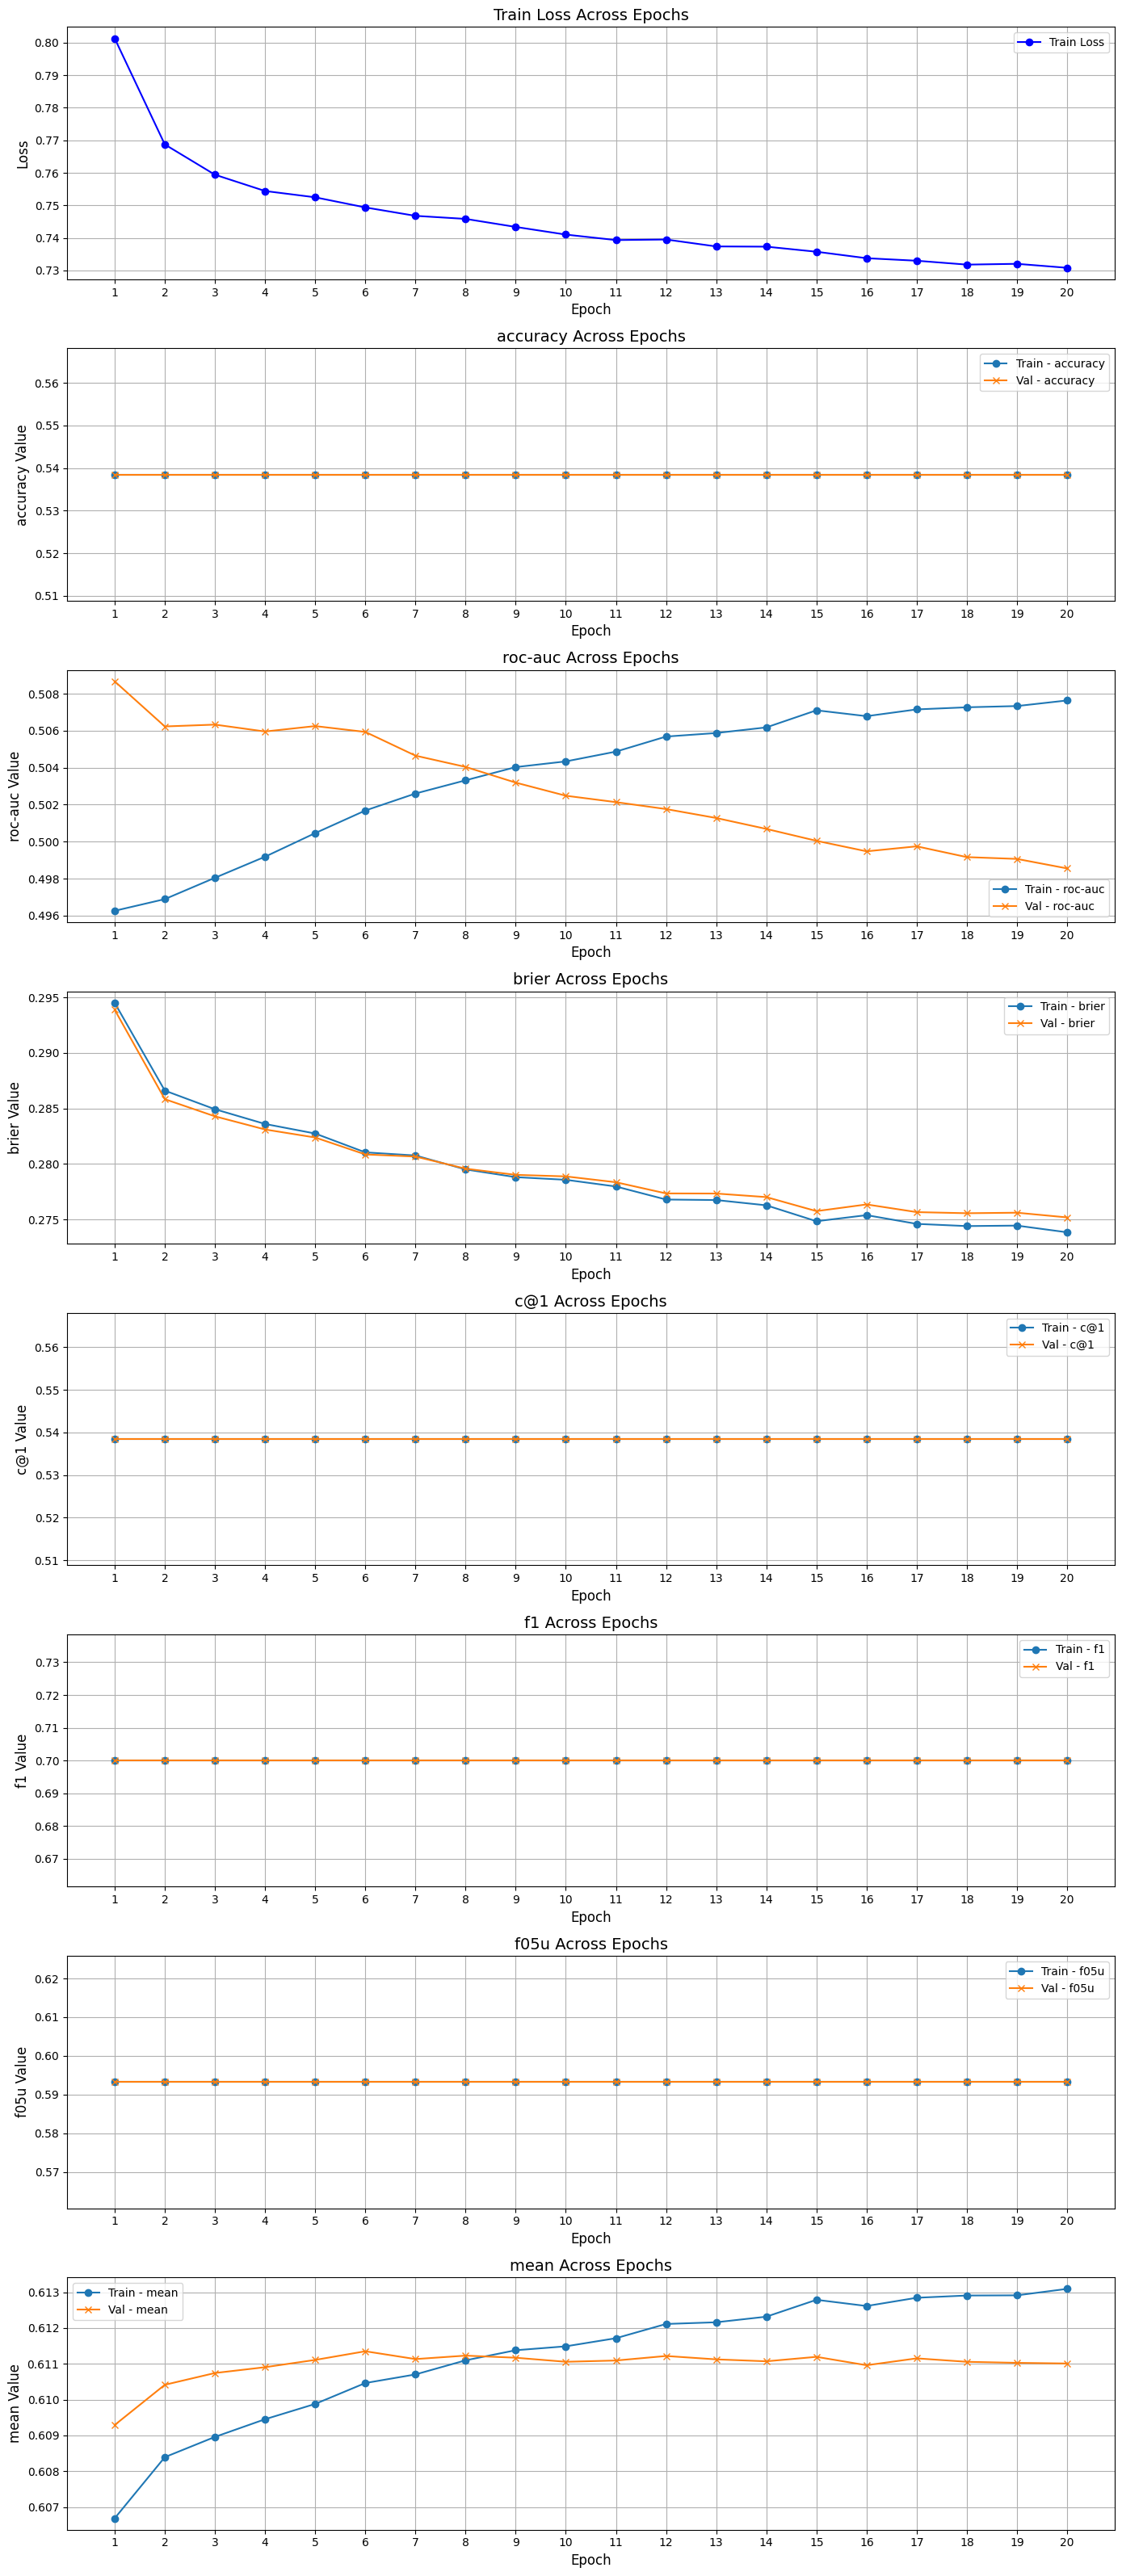

In [23]:
metric_names = history["val_metrics"][0].keys()
epochs = list(range(1, len(history["val_metrics"]) + 1))

train_values = {name: [epoch.get(name, None) for epoch in history["train_metrics"]] for name in metric_names}
val_values = {name: [epoch.get(name, None) for epoch in history["val_metrics"]] for name in metric_names}

num_subplots = len(metric_names) + 1  # Number of metrics + train loss
plt.figure(figsize=(14, 4 * num_subplots))  # Increase height proportional to the number of plots

# Plot train loss
plt.subplot(num_subplots, 1, 1)

plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o", color="blue")
plt.title("Train Loss Across Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.xticks(epochs)
plt.grid(True)
plt.legend()

# Plotting each metric in a separate graph
for idx, metric in enumerate(metric_names):
    plt.subplot(len(metric_names) + 1, 1, idx + 2)  # Adjust index for additional loss plot
    plt.plot(epochs, train_values[metric], label=f'Train - {metric}', marker='o')
    plt.plot(epochs, val_values[metric], label=f'Val - {metric}', marker='x')
    plt.title(f"{metric} Across Epochs", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(f"{metric} Value", fontsize=12)
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

## Final evaluation (Classification)

In [25]:
model = torch.load('models/models_siames_bert_congelado/fine_tuned_model_20_epochs_3e-05_lr_0_layers_256_batch_size_checkpoint_20.pth')

In [26]:
# Evaluación final en el conjunto de prueba
train_accuracy = evaluate(model, train_loader, device)
print(f"Train Metrics: {train_accuracy}")
val_accuracy = evaluate(model, val_loader, device)
print(f"Val Metrics: {val_accuracy}")
test_accuracy = evaluate(model, test_loader, device)
print(f"Test Metrics: {test_accuracy}")

Train Metrics: {'accuracy': 0.5384615384615384, 'roc-auc': 0.5076345859540846, 'brier': 0.2738509111085916, 'c@1': 0.5384615384615384, 'f1': 0.7000000000000001, 'f05u': 0.5932203389830508, 'mean': 0.6130931104580165}
Val Metrics: {'accuracy': 0.5384615384615384, 'roc-auc': 0.49855438498928983, 'brier': 0.27519247127461754, 'c@1': 0.5384615384615384, 'f1': 0.7000000000000001, 'f05u': 0.5932203389830508, 'mean': 0.6110087582318524}
Test Metrics: {'accuracy': 0.5384615384615384, 'roc-auc': 0.4989328451969023, 'brier': 0.27384061498755863, 'c@1': 0.5384615384615384, 'f1': 0.7000000000000001, 'f05u': 0.5932203389830508, 'mean': 0.6113548215307866}
